In [1]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [51]:
#Main parameters
d2s=86400 #24h in s
h2s=3600  #1h in s
w2=2*2*np.pi/86400 #wave pulsation
km=1e3
dt=1*h2s # model step
L=100*km
k2=2*np.pi/L

um=0.1
uw=0.1
w=w2
k=k2
t_i, t_e, t_step = 0,2*d2s,3600/5
x_i, x_e, x_step =0, 5*L, 10*km


def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))



In [52]:
#Creation of the velocity field to interpolate
t=np.arange(t_i,t_e,t_step)
x=np.arange(x_i,x_e,x_step)
len_t=len(t)
len_x=len(x)
VF=np.zeros((len_t, len_x))
for i in range(len_t):
    for j in range (len_x):
        VF[i,j]=analytical_velocity_advected(t[i], x[j], um, uw, w, k)

# Bilinear interpolation

In [53]:
#Interpolation function
def bilinear_int(p_liste,ts,VF,x,t, t_step, x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it2 = it1 + 1
    #print(it1,it2)
    if it2==len(t):
        return np.zeros_like(x)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1==len(x):
            v.append(0)
        else:
            ip2 = ip1 + 1
            #print(ip1,ip2)
        
            alpha=p-x[ip1]
            beta=ts-t[it1]
        
    
            delta_vx = VF[it1,ip2]-VF[it1,ip1]
            delta_vy = VF[it2,ip1]-VF[it1,ip1]
            delta_vxy = VF[it1,ip1] + VF[it2,ip2] - VF[it1,ip2] - VF[it2,ip1]
            v.append(delta_vx*alpha/x_step + delta_vy*beta/t_step + delta_vxy*alpha*beta/x_step/t_step + VF[it1,ip1])
    return v


In [55]:
#Interpolated velocity field

t_inter=np.arange(t_i,d2s,t_step*0.5)
x_inter=np.arange(x_i,L,x_step*0.5)

V_inter=[]
for tp in t_inter:
    V_inter.append(bilinear_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))



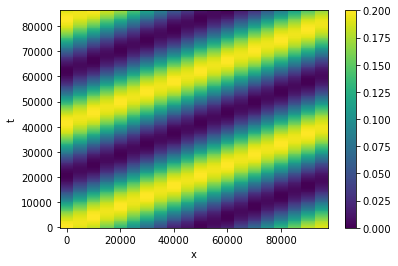

In [56]:
v_inter.plot()

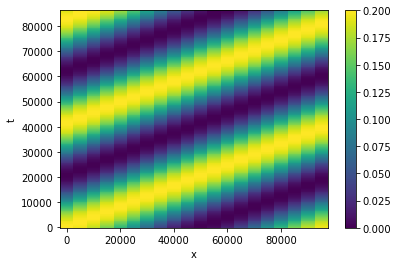

In [57]:
#Analytical velocity on the interpolated grid
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
v_analytical.plot()

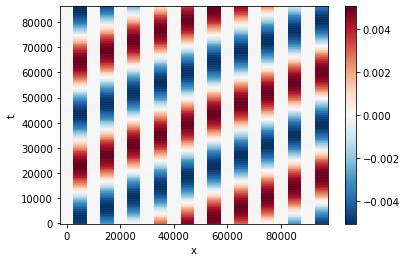

In [58]:
(v_inter-v_analytical).plot()

In [59]:
#Interpolated velocity with the x array method interp()
v_xr=vf.interp(t=t_inter, x=x_inter)

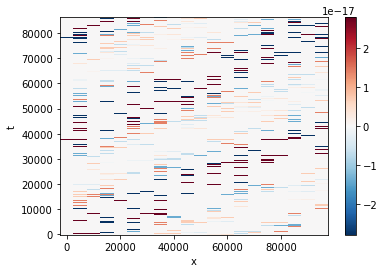

In [60]:
(v_inter-v_xr).plot()

# Lagrange interpolation

In [54]:
def lagrange_int(p_liste,ts,VF,x,t,t_step,x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it=[it1+o for o in [-1,0,1,2]]

    #print(it1,it2)
    if it1+1>=len(t) or it1==0:
        print('t out of velocity flield :'+ str(ts))
        return np.zeros_like(p_liste)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1>=len(x) or ip1==0:
            print('x out of velocity field')
            v.append(0)
        else:
            ip=[ip1+o for o in [-1,0,1,2]]
            v_sum=0
            for i in range(4):
                for j in range(4):
                    prod1=1
                    prod2=1
                    prod3=1
                    prod4=1
                    for r in range(4):
                        if r!=i:
                            prod1*=p-x[ip[r]]
                            prod2*=x[ip[i]]-x[ip[r]]
                        if r!=j:
                            prod3*=ts-t[it[r]]
                            prod4*=t[it[j]]-t[it[r]]
                    v_sum+=VF[it[j], ip[i]]*(prod1*prod3)/(prod2*prod4)
            v.append(v_sum)
    return np.array(v)


In [69]:
#Interpolated velocity field

t_inter=np.arange(t_i+t_step,d2s,t_step*0.5)
x_inter=np.arange(x_i+x_step,L,x_step*0.5)

V_inter=[]
for tp in t_inter:
    V_inter.append(bilinear_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))



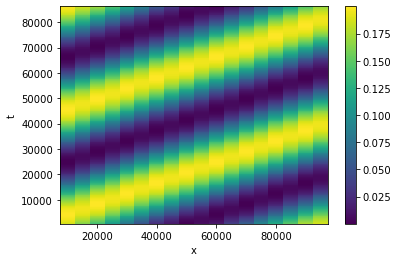

In [70]:
v_inter.plot()

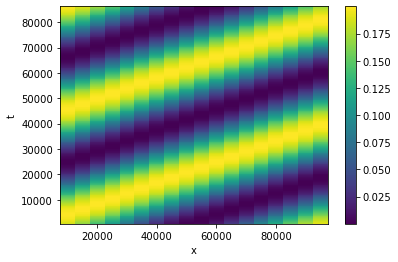

In [71]:
#Analytical velocity on the interpolated grid
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
v_analytical.plot()

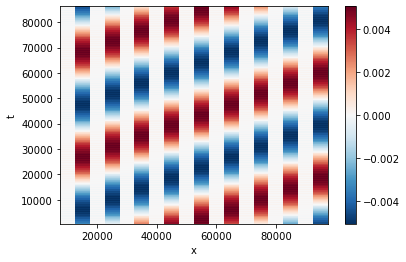

In [72]:
(v_inter-v_analytical).plot()